# 0. Data Exploration and Quality Check

This notebook performs exploratory checks on the raw datasets to evaluate data availability, quality, and alignment for GRACE downscaling.

In [3]:
import os
import glob
import xarray as xr
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from rasterio.plot import show
from datetime import datetime
from matplotlib.dates import DateFormatter
%matplotlib inline

#plt.style.use('seaborn-whitegrid')


In [6]:
RAW_DIR = "../data/raw"
DATASETS = {
    "GRACE": os.path.join(RAW_DIR, "grace"),
    "GLDAS": os.path.join(RAW_DIR, "gldas"),
    "CHIRPS": os.path.join(RAW_DIR, "chirps"),
    "MODIS_LC": os.path.join(RAW_DIR, "modis_land_cover"),
    "DEM": os.path.join(RAW_DIR, "usgs_dem"),
    "TERRACLIMATE": os.path.join(RAW_DIR, "terraclimate"),
    "WELLS": os.path.join(RAW_DIR, "usgs_well_data", "monthly_groundwater_anomalies.csv")
}


Found 155 GRACE files. Example file: ../data/raw/grace/20030131_20030227.tif


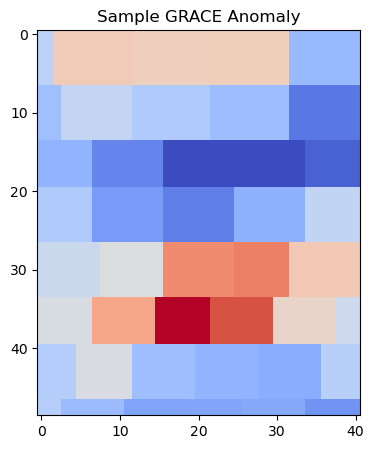

<Axes: title={'center': 'Sample GRACE Anomaly'}>

In [7]:
grace_files = sorted(glob.glob(os.path.join(DATASETS["GRACE"], "*.tif")))
print(f"Found {len(grace_files)} GRACE files. Example file: {grace_files[0]}")

with rasterio.open(grace_files[0]) as src:
    grace_data = src.read(1)
    grace_meta = src.meta

plt.figure(figsize=(6, 5))
plt.title("Sample GRACE Anomaly")
show(grace_data, cmap="coolwarm")


Found 240 CHIRPS files. Example: ../data/raw/chirps/0.tif


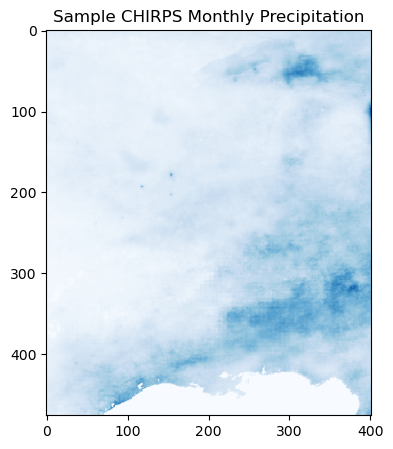

<Axes: title={'center': 'Sample CHIRPS Monthly Precipitation'}>

In [8]:
chirps_files = sorted(glob.glob(os.path.join(DATASETS["CHIRPS"], "*.tif")))
print(f"Found {len(chirps_files)} CHIRPS files. Example: {chirps_files[0]}")

with rasterio.open(chirps_files[0]) as src:
    chirps_data = src.read(1)

plt.figure(figsize=(6, 5))
plt.title("Sample CHIRPS Monthly Precipitation")
show(chirps_data, cmap="Blues")


Loaded well data with shape: (3, 3469)


Text(0.5, 0, 'Time')

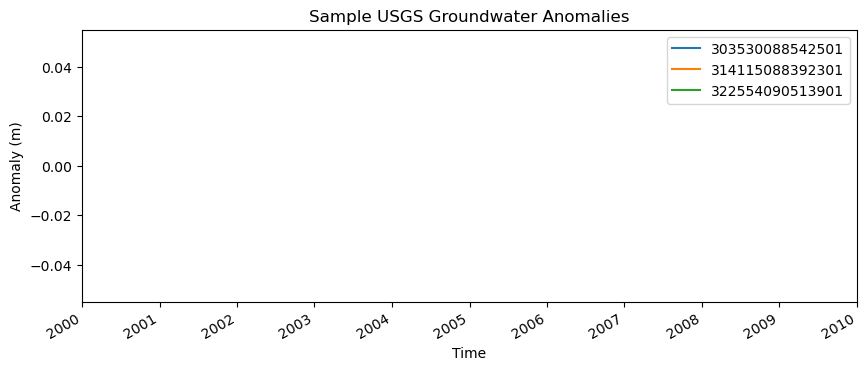

In [9]:
wells_df = pd.read_csv(DATASETS["WELLS"], index_col="Date", parse_dates=True)
print(f"Loaded well data with shape: {wells_df.shape}")
wells_df.iloc[:, :3].plot(figsize=(10, 4), title="Sample USGS Groundwater Anomalies")
plt.ylabel("Anomaly (m)")
plt.xlabel("Time")


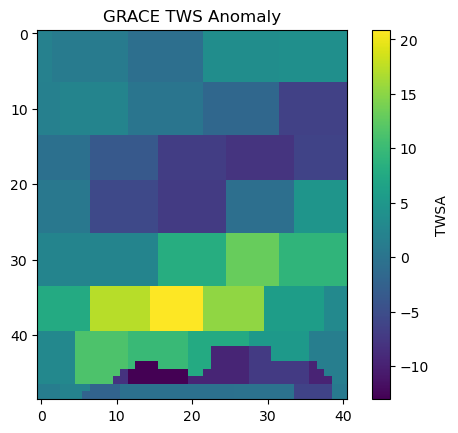

In [15]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("../data/raw/grace/20030131_20030227.tif") as src:
    data = src.read(1)
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='TWSA')
    plt.title("GRACE TWS Anomaly")
    plt.show()


In [12]:
from dateutil.relativedelta import relativedelta

def extract_dates_from_filenames(filelist):
    dates = []
    for f in filelist:
        fname = os.path.basename(f)
        digits = ''.join(c for c in fname if c.isdigit())
        if len(digits) >= 6:
            try:
                dates.append(datetime.strptime(digits[:6], "%Y%m"))
            except:
                continue
    return sorted(dates)

def generate_dates_for_indexed_files(filelist, start="2003-01"):
    start_date = datetime.strptime(start, "%Y-%m")
    return [start_date + relativedelta(months=i) for i in range(len(filelist))]

# Determine per dataset
date_summary = {}

# GRACE: use date from filenames
grace_files = sorted(glob.glob(os.path.join(DATASETS["GRACE"], "*.tif")))
date_summary["GRACE"] = extract_dates_from_filenames(grace_files)

# CHIRPS: use indexed fallback
chirps_files = sorted(glob.glob(os.path.join(DATASETS["CHIRPS"], "*.tif")), key=lambda x: int(os.path.basename(x).split(".")[0]))
date_summary["CHIRPS"] = generate_dates_for_indexed_files(chirps_files)

# Print results
for k, v in date_summary.items():
    if len(v) > 0:
        print(f"{k}: {len(v)} months from {v[0]} to {v[-1]}")
    else:
        print(f"{k}: ⚠️ No dates found.")


GRACE: 155 months from 2003-01-01 00:00:00 to 2017-05-01 00:00:00
CHIRPS: 240 months from 2003-01-01 00:00:00 to 2022-12-01 00:00:00


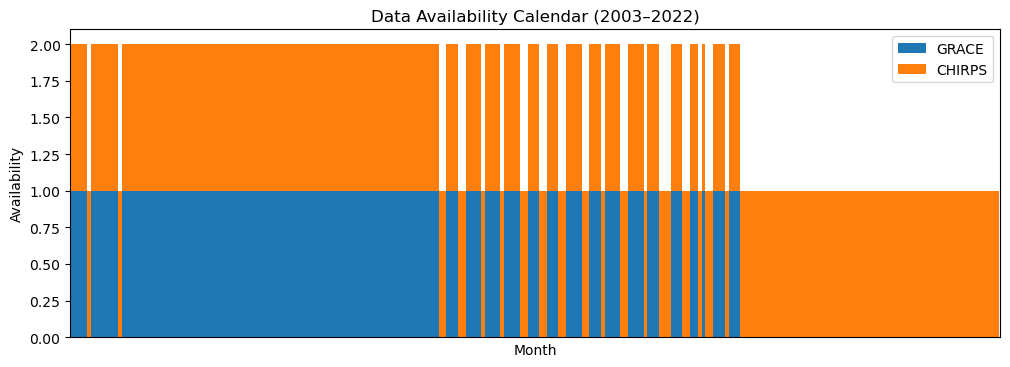

In [13]:
df = pd.DataFrame(index=pd.date_range("2003-01", "2022-12", freq="MS"))
for k in date_summary:
    df[k] = df.index.isin(date_summary[k]).astype(int)

df.plot(kind="bar", stacked=True, figsize=(12, 4), width=1, title="Data Availability Calendar (2003–2022)")
plt.ylabel("Availability")
plt.xlabel("Month")
plt.xticks([])
plt.legend(loc='upper right')


## Summary

- ✅ Loaded and visualized samples from GRACE, CHIRPS, and USGS wells.
- ✅ Verified time coverage and monthly availability from 2003 to 2022.
- ⏭️ Next: Preprocess datasets to anomalies (for RF training) in `features.py`:
  - Normalize dynamic datasets (monthly climatology subtraction)
  - Normalize or encode static datasets
  - Align all to common grid and time axis


In [26]:
import xarray as xr
ds = xr.open_dataset("../data/processed/feature_stack.nc")
print(ds)
print(ds.feature.values[:10])  # Check naming


<xarray.Dataset> Size: 27MB
Dimensions:      (x: 41, y: 49, feature: 1693)
Coordinates:
    band         int64 8B ...
  * x            (x) float64 328B -99.83 -99.38 -98.93 ... -82.76 -82.31 -81.86
  * y            (y) float64 392B 49.35 48.9 48.45 48.0 ... 28.69 28.24 27.79
  * feature      (feature) <U24 163kB 'chirps_2003-01' ... 'usgs_dem_srtm_dem'
Data variables:
    spatial_ref  int64 8B ...
    features     (feature, y, x) float64 27MB ...
['chirps_2003-01' 'chirps_2003-02' 'chirps_2003-03' 'chirps_2003-04'
 'chirps_2003-05' 'chirps_2003-06' 'chirps_2003-07' 'chirps_2003-08'
 'chirps_2003-09' 'chirps_2003-10']


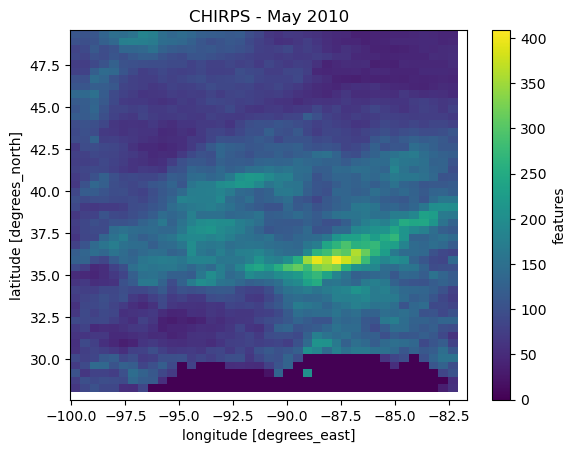

In [28]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
ds = xr.open_dataset("../data/processed/feature_stack.nc")

# Select and plot one feature
da = ds.features.sel(feature="chirps_2010-05")
da.plot()
plt.title("CHIRPS - May 2010")
plt.show()


In [29]:
import xarray as xr

ds = xr.open_dataset("../data/processed/feature_stack.nc")
print(ds)

print("\nFeature Names Sample:")
print(ds.feature.values[:10])

print("\nTotal Features:", len(ds.feature))
print("Dimensions:", ds.dims)
print("Variable Names:", list(ds.data_vars))


<xarray.Dataset> Size: 27MB
Dimensions:      (x: 41, y: 49, feature: 1693)
Coordinates:
    band         int64 8B ...
  * x            (x) float64 328B -99.83 -99.38 -98.93 ... -82.76 -82.31 -81.86
  * y            (y) float64 392B 49.35 48.9 48.45 48.0 ... 28.69 28.24 27.79
  * feature      (feature) <U24 163kB 'chirps_2003-01' ... 'usgs_dem_srtm_dem'
Data variables:
    spatial_ref  int64 8B ...
    features     (feature, y, x) float64 27MB ...

Feature Names Sample:
['chirps_2003-01' 'chirps_2003-02' 'chirps_2003-03' 'chirps_2003-04'
 'chirps_2003-05' 'chirps_2003-06' 'chirps_2003-07' 'chirps_2003-08'
 'chirps_2003-09' 'chirps_2003-10']

Total Features: 1693
Dimensions: FrozenMappingWarningOnValuesAccess({'x': 41, 'y': 49, 'feature': 1693})
Variable Names: ['spatial_ref', 'features']


In [30]:
import xarray as xr
import numpy as np

# Load the NetCDF file
path = "../data/processed/feature_stack.nc"
ds = xr.open_dataset(path)

print("\n📦 Feature Stack Summary")
print("Shape:", ds.features.shape)

# Count features
all_features = ds.feature.values
num_features = len(all_features)
print("Total features:", num_features)

# Check temporal vs static
temporal = [f for f in all_features if any(str(y) in f for y in range(2002, 2025))]
static = [f for f in all_features if f not in temporal]

print("\n📆 Temporal features:", len(temporal))
print("🧱 Static features:", len(static))

# Feature group summary
print("\n📊 Feature counts by dataset prefix:")
from collections import Counter
prefix_counts = Counter([f.split("_")[0] for f in temporal + static])
for k, v in prefix_counts.items():
    print(f"  - {k}: {v}")

# NaN summary
nan_ratio = float(np.isnan(ds.features.data).sum()) / ds.features.data.size
print(f"\n🧪 NaN fraction: {nan_ratio:.4f}")


📦 Feature Stack Summary
Shape: (1691, 49, 41)
Total features: 1691

📆 Temporal features: 1198
🧱 Static features: 493

📊 Feature counts by dataset prefix:
  - chirps: 197
  - pr: 197
  - tmmn: 197
  - tmmx: 197
  - aet: 197
  - def: 197
  - modis: 16
  - evap: 240
  - swe: 240
  - openlandmap: 12
  - usgs: 1

🧪 NaN fraction: 0.0442


In [33]:
from datetime import datetime
import os

def generate_index_based_timestamp_map(start_date="2003-01", num_months=240):
    """Generate a mapping: '0.tif' -> '2003-01', ..., '239.tif' -> '2022-12'"""
    start = datetime.strptime(start_date, "%Y-%m")
    timestamp_map = {
        f"{i}.tif": (start.replace(day=1) if i == 0 else (start.replace(day=1) + pd.DateOffset(months=i))).strftime("%Y-%m")
        for i in range(num_months)
    }
    return timestamp_map

def validate_file_timestamps(folder_path, expected_count=240, start_date="2003-01"):
    timestamp_map = generate_index_based_timestamp_map(start_date=start_date, num_months=expected_count)
    files = sorted(f for f in os.listdir(folder_path) if f.endswith(".tif") and f.split('.')[0].isdigit())
    
    missing = [f"{i}.tif" for i in range(expected_count) if f"{i}.tif" not in files]
    extra = [f for f in files if f not in timestamp_map]
    aligned = [f for f in files if f in timestamp_map]

    print(f"\n📂 Checking folder: {folder_path}")
    print(f"✅ Total expected: {expected_count}")
    print(f"✅ Found: {len(files)}")
    print(f"✅ Aligned with timestamp map: {len(aligned)}")
    print(f"❌ Missing files: {len(missing)}")
    if missing:
        print(f"   ⤷ Sample missing: {missing[:5]}")
    if extra:
        print(f"❌ Extra/unmapped files found: {extra[:5]}")

    return {
        "aligned_files": aligned,
        "missing_files": missing,
        "extra_files": extra,
        "timestamp_map": timestamp_map
    }


results = validate_file_timestamps("../data/raw/gldas/SoilMoi0_10cm_inst", start_date="2003-01")



📂 Checking folder: ../data/raw/gldas/SoilMoi0_10cm_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
❌ Missing files: 0


In [35]:
import os
from datetime import datetime
from pathlib import Path

# Expected timeline: 240 months from Jan 2003 to Dec 2022
expected_timestamps = [
    datetime(2003 + (i // 12), (i % 12) + 1, 1).strftime("%Y-%m")
    for i in range(240)
]

# Root folder for GLDAS data
root_dir = Path("../data/raw/")

# Check each subfolder
for subfolder in sorted(root_dir.iterdir()):
    if not subfolder.is_dir():
        continue

    tif_files = sorted([f for f in subfolder.glob("*.tif") if f.is_file()])
    n_files = len(tif_files)

    print(f"\n📂 Checking folder: {subfolder}")
    print(f"✅ Total expected: {len(expected_timestamps)}")
    print(f"{'✅' if n_files == 240 else '❌'} Found: {n_files}")

    aligned = True
    for i, tif in enumerate(tif_files):
        expected_name = f"{i}.tif"
        if tif.name != expected_name:
            aligned = False
            break

    if aligned:
        print(f"✅ Aligned with timestamp map: {n_files}")
    else:
        print(f"❌ Aligned with timestamp map: 0")

    missing = 240 - n_files
    print(f"{'❌' if missing else '✅'} Missing files: {missing}")



📂 Checking folder: ../data/raw/chirps
✅ Total expected: 240
✅ Found: 240
❌ Aligned with timestamp map: 0
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas
✅ Total expected: 240
❌ Found: 0
✅ Aligned with timestamp map: 0
❌ Missing files: 240

📂 Checking folder: ../data/raw/grace
✅ Total expected: 240
❌ Found: 208
❌ Aligned with timestamp map: 0
❌ Missing files: 32

📂 Checking folder: ../data/raw/modis_land_cover
✅ Total expected: 240
❌ Found: 20
❌ Aligned with timestamp map: 0
❌ Missing files: 220

📂 Checking folder: ../data/raw/openlandmap
✅ Total expected: 240
❌ Found: 12
❌ Aligned with timestamp map: 0
❌ Missing files: 228

📂 Checking folder: ../data/raw/terraclimate
✅ Total expected: 240
❌ Found: 0
✅ Aligned with timestamp map: 0
❌ Missing files: 240

📂 Checking folder: ../data/raw/usgs_dem
✅ Total expected: 240
❌ Found: 1
❌ Aligned with timestamp map: 0
❌ Missing files: 239

📂 Checking folder: ../data/raw/usgs_well_data
✅ Total expected: 240
❌ Found: 0
✅ Aligned with timest

In [37]:
import os
from datetime import datetime
from pathlib import Path

# Set root directories
root_dir = Path("../data/raw")
folders_to_check = [
    "gldas/Evap_tavg",
    "gldas/SWE_inst",
    "gldas/SoilMoi0_10cm_inst",
    "gldas/SoilMoi10_40cm_inst",
    "gldas/SoilMoi40_100cm_inst",
    "gldas/SoilMoi100_200cm_inst",
    "chirps",
    "grace",
    "modis_land_cover",
    "openlandmap",
    "terraclimate/aet",
    "terraclimate/def",
    "terraclimate/tmmx",
    "terraclimate/tmmn",
    "terraclimate/pr",
    "usgs_dem",
    "usgs_well_data"
]

# Generate expected 240 timestamps (2003-01 to 2022-12)
expected_dates = [datetime(2003, 1, 1).replace(month=((i % 12) + 1), year=2003 + i // 12).strftime('%Y-%m') for i in range(240)]

print("📂 Validating Timestamp Alignment\n")
for folder in folders_to_check:
    folder_path = root_dir / folder
    if not folder_path.exists():
        print(f"📂 Folder not found: {folder}")
        continue

    files = sorted(folder_path.glob("*.tif"), key=lambda f: int(f.stem) if f.stem.isdigit() else float('inf'))
    found = len(files)
    aligned = 0
    missing = max(0, 240 - found)

    # For numeric file names like 0.tif, 1.tif...
    file_ids = [f.stem for f in files]
    if all(fid.isdigit() for fid in file_ids):
        aligned = min(240, found)  # Assume alignment by index
    else:
        aligned = sum(any(d.replace("-", "") in fname for fname in file_ids) for d in expected_dates)

    print(f"📂 Checking folder: {folder_path}")
    print(f"✅ Total expected: 240")
    print(f"{'✅' if found == 240 else '❌'} Found: {found}")
    print(f"{'✅' if aligned == 240 else '❌'} Aligned with timestamp map: {aligned}")
    print(f"{'✅' if missing == 0 else '❌'} Missing files: {missing}\n")


📂 Validating Timestamp Alignment

📂 Checking folder: ../data/raw/gldas/Evap_tavg
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas/SWE_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas/SoilMoi0_10cm_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas/SoilMoi10_40cm_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas/SoilMoi40_100cm_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/gldas/SoilMoi100_200cm_inst
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ Missing files: 0

📂 Checking folder: ../data/raw/chirps
✅ Total expected: 240
✅ Found: 240
✅ Aligned with timestamp map: 240
✅ 

In [39]:
from pathlib import Path
import re
from datetime import datetime

def extract_grace_months_from_ranges(grace_dir):
    months = []
    for f in Path(grace_dir).glob("*.tif"):
        m = re.search(r'_(\d{8})\.tif$', f.name)  # extract second date
        if m:
            dt = datetime.strptime(m.group(1), "%Y%m%d")
            ym = dt.strftime("%Y-%m")
            months.append(ym)
    return sorted(set(months))

# Run this
grace_months = extract_grace_months_from_ranges("../data/raw/grace")
print(f"✅ Valid GRACE months: {len(grace_months)}")
print(grace_months[:5], "...", grace_months[-5:])


✅ Valid GRACE months: 203
['2003-02', '2003-03', '2003-04', '2003-05', '2003-07'] ... ['2022-08', '2022-09', '2022-10', '2022-11', '2022-12']


usage: ipykernel_launcher.py [-h] [--no-report] [--no-plots] [--quiet]
                             filepath
ipykernel_launcher.py: error: the following arguments are required: filepath


SystemExit: 2

/home/sauravbhattarai/.conda/envs/grace-downscaling/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
